In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=UserWarning)

In [163]:
import pandas as pd
import numpy as np
from utilities import *
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

In [164]:
from sklearn import set_config
set_config(transform_output="pandas")
set_config(display='diagram')

In [165]:
X_train, y_train, X_test, y_test = load_data()
selected_columns = np.load("./data/selected_columns.npy", allow_pickle=True)

In [166]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
model_errors = {}
regresion_function = DecisionTreeRegressor()

### Baseline

In [167]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', CategoricalEncoder())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["1.baseline"] = test_model(model, X_train, y_train, X_test, y_test)

### Add One Hot Encoder

In [168]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["2.+OneHotEncoder"] = test_model(model, X_train, y_train, X_test, y_test)

### Normalize numeric data with MinMax

In [169]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('normalizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["3.+numNormalize"] = test_model(model, X_train, y_train, X_test, y_test)

### Remove outliers

In [170]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop="if_binary", max_categories=10, min_frequency=0.001, sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('remove_outliers', OutlierTransformer()),
    ('normalizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["4.-outliers"] = test_model(model, X_train, y_train, X_test, y_test)

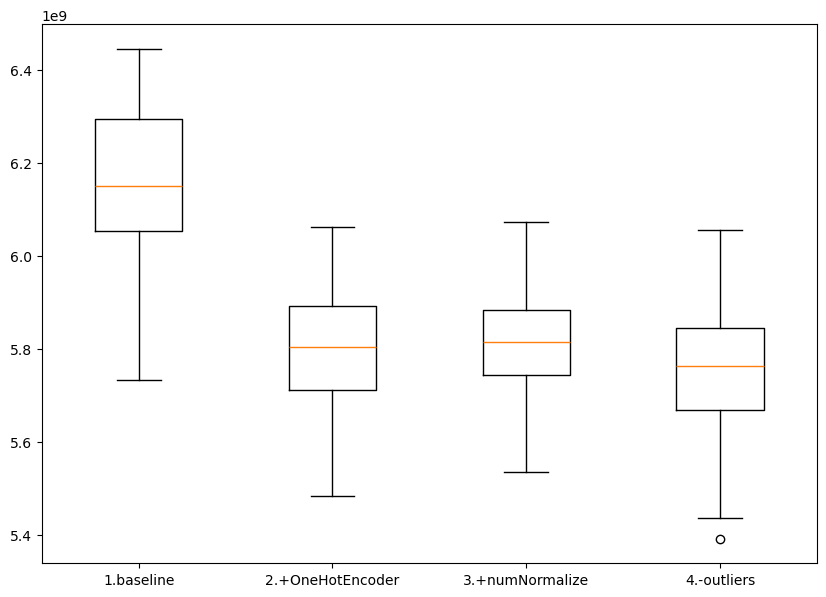

In [171]:
compare_errors(model_errors)